In [1]:
from numba import njit, jit
import numpy as np
import os

def move_to_parent_dir():
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    print("Working directory:", os.getcwd())

move_to_parent_dir() 

Working directory: c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19


# Load Tapes Data

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv
Opening UoB_Set01_2025-01-07tapes.csv
Opening UoB_Set01_2025-01-08tapes.csv
Opening UoB_Set01_2025-01-09tapes.csv
Opening UoB_Set01_2025-01-10tapes.csv
Opening UoB_Set01_2025-01-13tapes.csv
Opening UoB_Set01_2025-01-14tapes.csv
Opening UoB_Set01_2025-01-15tapes.csv
Opening UoB_Set01_2025-01-16tapes.csv
Opening UoB_Set01_2025-01-17tapes.csv
Opening UoB_Set01_2025-01-20tapes.csv
Opening UoB_Set01_2025-01-21tapes.csv
Opening UoB_Set01_2025-01-22tapes.csv
Opening UoB_Set01_2025-01-23tapes.csv
Opening UoB_Set01_2025-01-24tapes.csv
Opening UoB_Set01_2025-01-27tapes.csv
Opening UoB_Set01_2025-01-28tapes.csv
Opening UoB_Set01_2025-01-29tapes.csv
Opening UoB_Set01_2025-01-30tapes.csv
Opening UoB_Set01_2025-01-31tapes.csv
Opening UoB_Set01_2025-02-03tapes.csv
Opening UoB_Set01_2025-02-04tapes.csv
Opening UoB_Set01_2025-02-05tapes.csv
Opening UoB_Set01_2025-02-06tapes.csv
Opening UoB_

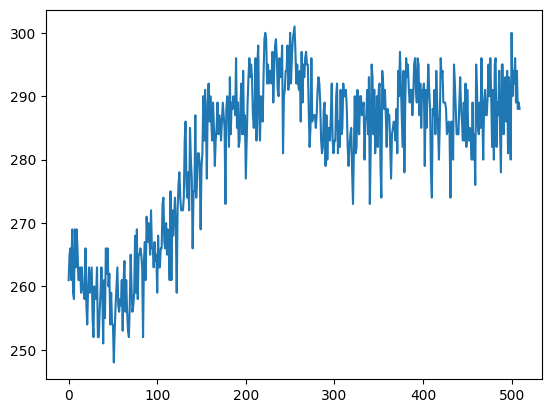

In [2]:
# get test data
import matplotlib.pyplot as plt
from tools import get_Tapes
raw_tapes = get_Tapes(125,0)
tapes_data = [t["Price"].resample("1min").last().ffill().to_numpy() for t in raw_tapes]
plt.plot(tapes_data[0])

# Define Broker and Example Agent

In [3]:
def broker(actor, price_data: np.array, starting_cash: int):
    time_index = 0
    final_time_index = price_data.shape[0]
    num_stocks = np.zeros_like(price_data)
    cash_value = np.zeros_like(price_data)
    cash_value[0] = starting_cash

    while True:
        action = actor(price_data[:time_index], cash_value[time_index], num_stocks[time_index])

        if action == 1: # buy one stock
            if cash_value[time_index] >= price_data[time_index]:
                cash_value[time_index] = cash_value[time_index] - price_data[time_index]
                num_stocks[time_index] = num_stocks[time_index] + 1

        elif action == 2: # sell one stock
            if num_stocks[time_index] > 0:
                num_stocks[time_index] = num_stocks[time_index] - 1
                cash_value[time_index] = cash_value[time_index] + price_data[time_index]
        else: # do nothing
            pass


        time_index += 1
        if time_index >= final_time_index:
            break

        num_stocks[time_index] = num_stocks[time_index - 1]
        cash_value[time_index] = cash_value[time_index - 1]

    total_value = num_stocks * price_data + cash_value
    accuracy = (total_value[-1] / starting_cash)**2

    return num_stocks, cash_value, total_value, accuracy

@njit
def random_actor(current_data, current_cash, current_stocks):
    return np.random.randint(1,3)

1.15089984


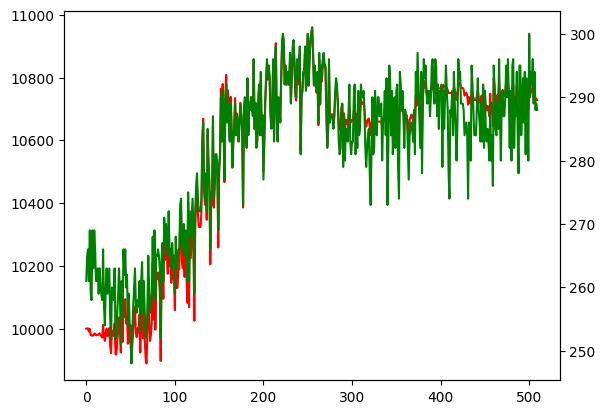

In [4]:
num_stocks, cash_value, total_value, acc = broker(random_actor, tapes_data[0], 10000)
print(acc)
plt.plot(total_value, 'r')
plt.twinx()
plt.plot(tapes_data[0], 'g')
plt.show()

# Sample Cross Validation

In [5]:
def generate_folds(tapes_data, n_folds=5):
    fold_size = len(tapes_data) // n_folds
    
    for i in range(n_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < n_folds - 1 else len(tapes_data)
        
        test_indices = np.arange(start_index,end_index,1, dtype=int)
        # Test split
        test_data = tapes_data[test_indices]
        
        # Training split
        train_data = np.delete(tapes_data, test_indices, axis=0)
        
        yield train_data, test_data

for a in generate_folds(np.array(tapes_data)):
    print(len(a[0]), len(a[1]))

100 25
100 25
100 25
100 25
100 25


In [6]:
import numpy as np
@njit
def MA_actor(current_data, current_cash, current_stocks, ma_window = 1, eps = 0):
    if len(current_data) == 0:
        return 0
    ma = np.mean(current_data[-ma_window:])
    if current_data[-1] > ma + eps:
        return 2
    elif current_data[-1] < ma - eps:
        return 1
    else:
        return 0

test_scores = []
ma_windows = [2,4,8,16,32,64,128,256,512,1024]
eps_windows = [0,1,2,4,8]
for train_data, test_data in generate_folds(np.array(tapes_data)):
    train_scores = []
    
    # TRAINING PHASE
    # Iterate over MA windows and epsilon windows
    for w in ma_windows:
        for e in eps_windows:
            act = lambda a, b, c: MA_actor(a, b, c, w, e)
            score = 0
            
            # Calculate score for each data point in training data
            for data in train_data:
                n, c, t, a = broker(act, data, 10_000)
                score += a
                
            train_scores.append(score)
            
    # Find optimal window size
    max_score_index = np.argmax(train_scores)
    optimal_window_index = max_score_index // len(eps_windows)
    optimal_e_index = max_score_index % len(eps_windows)
    optimal_window = ma_windows[optimal_window_index]
    optimal_e = eps_windows[optimal_e_index]
    
    print("Optimal Window:", optimal_window)
    print("Optimal Epsilon:", optimal_e)

    # TESTING PHASE
    
    # Calculate test scores using optimal parameters
    act_optimal = lambda a, b, c: MA_actor(a, b, c, optimal_window, optimal_e)
    test_score = 0
    
    # Calculate score for each data point in test data
    for data in test_data:
        n, c, t, a = broker(act_optimal, data, 10_000)
        test_score += a
        
    test_scores.append(test_score / len(test_data))

# Return test scores
test_scores

Optimal Window: 4
Optimal Epsilon: 1
Optimal Window: 4
Optimal Epsilon: 1
Optimal Window: 4
Optimal Epsilon: 1
Optimal Window: 4
Optimal Epsilon: 1
Optimal Window: 4
Optimal Epsilon: 1


[1.0043350088,
 1.0024475583999999,
 0.9994604908,
 1.0027596864000001,
 0.9998581567999999]

In [7]:

@njit
def MA_cross_actor(current_data, current_cash, current_stocks, ma_window1 = 1, ma_window2 = 1):
    if len(current_data) == 0:
        return 0
    ma1 = np.mean(current_data[-ma_window1:])
    ma2 = np.mean(current_data[-ma_window2:])
    if ma1 > ma2:
        return 2
    elif ma2 > ma1:
        return 1
    else:
        return 0

test_scores = []
ma_windows = [2,4,8,16,32,64,128,256,512,1024]
for train_data, test_data in generate_folds(np.array(tapes_data)):
    train_scores = []
    
    # TRAINING PHASE
    # Iterate over MA windows for both MA actors
    for w1 in ma_windows:
        for w2 in ma_windows:
            if w1 == w2:
                train_scores.append(0)
            else:
                act = lambda a, b, c: MA_cross_actor(a, b, c, w1, w2)
                score = 0
                
                # Calculate score for each data point in training data
                for data in train_data:
                    n, c, t, a = broker(act, data, 10_000)
                    score += acc
                    
                train_scores.append(score)
            
    # Find optimal window size
    max_score_index = np.argmax(train_scores)
    optimal_window_index = max_score_index // len(ma_windows)
    optimal_window1 = ma_windows[optimal_window_index]
    optimal_window2 = ma_windows[max_score_index % len(ma_windows)]
    
    print("Optimal Window 1:", optimal_window1)
    print("Optimal Window 2:", optimal_window2)

    # TESTING PHASE
    
    # Calculate test scores using optimal parameters
    act_optimal = lambda a, b, c: MA_cross_actor(a, b, c, optimal_window1, optimal_window2)
    test_score = 0
    
    # Calculate score for each data point in test data
    for data in test_data:
        n, c, t, a = broker(act_optimal, data, 10_000)
        test_score += a
        
    test_scores.append(test_score / len(test_data))

# Return test scores
test_scores

Optimal Window 1: 2
Optimal Window 2: 4
Optimal Window 1: 2
Optimal Window 2: 4
Optimal Window 1: 2
Optimal Window 2: 4
Optimal Window 1: 2
Optimal Window 2: 4
Optimal Window 1: 2
Optimal Window 2: 4


[0.9965298276,
 0.9917347060000001,
 0.9983665724,
 0.9994315784000001,
 0.9980597355999998]

0.994009


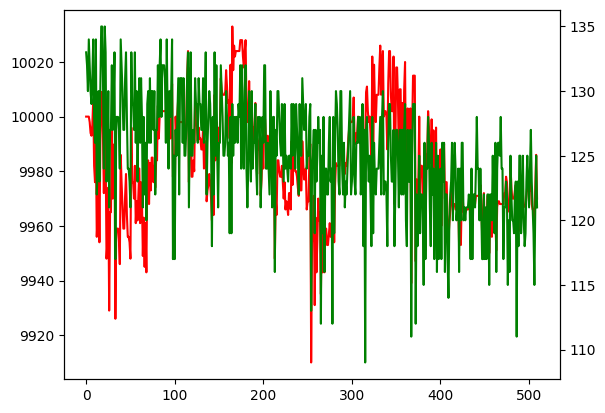

In [8]:
index = 100
act_optimal = lambda a, b, c: MA_cross_actor(a, b, c, 2, 4)
num_stocks, cash_value, total_value, a = broker(act_optimal, tapes_data[index], 10000)
print(a)
plt.plot(total_value, 'r')
plt.twinx()
plt.plot(tapes_data[index], 'g')
plt.show()